In [31]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from scipy.stats import skew
from imutils import face_utils
from numpy.fft import fft2, fftshift
import random

# 1 - Reading Images

In [2]:
realistic_images = np.load("realistic-faces.npy")
digital_art_images = np.load("digital-art-faces.npy")

In [3]:
print(f'realistic faces shape: {realistic_images.shape}')
print(f'digital faces shape: {digital_art_images.shape}')

realistic faces shape: (128, 512, 512, 3)
digital faces shape: (128, 512, 512, 3)


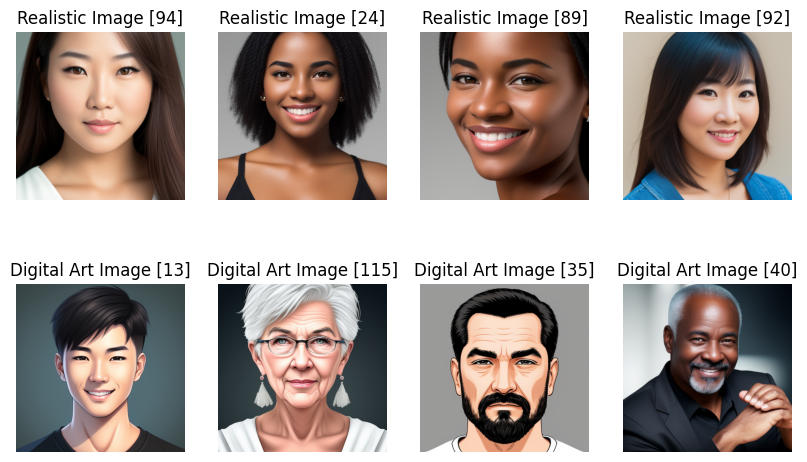

In [18]:
# Displaying a 3x3 grid
fig, axes = plt.subplots(2, 4, figsize=(10, 6))
for i in range(4):
    index = random.randint(0, 127)
    axes[0, i].imshow(cv2.cvtColor(realistic_images[index], cv2.COLOR_BGR2RGB))
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Realistic Image [{index}]")

    index = random.randint(0, 127)
    axes[1, i].imshow(cv2.cvtColor(digital_art_images[index], cv2.COLOR_BGR2RGB))
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Digital Art Image [{index}]")
plt.show()

# 2 - Color Description

## 2.1 - Color Histogram

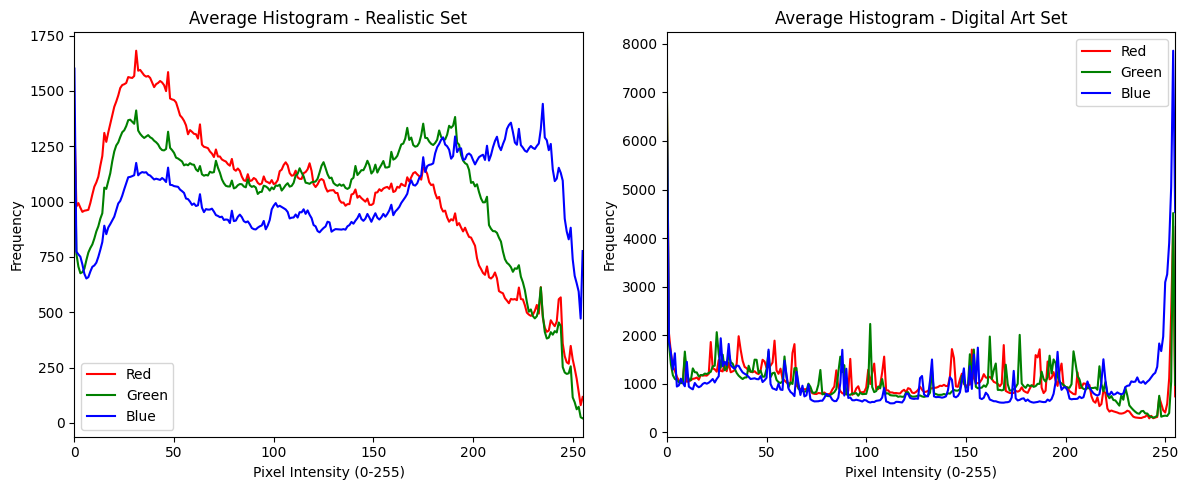

In [27]:
def extract_color_histogram(image, bins=256):
    """Extracts color histograms for the three RGB channels."""
    hist = []
    for i in range(3):
        hist.append(cv2.calcHist([image], [i], None, [bins], [0, 256]).flatten())
    return np.array(hist)

# Extract histograms for both datasets
realistic_hist = [extract_color_histogram(img) for img in realistic_images]
digital_hist = [extract_color_histogram(img) for img in digital_art_images]

# Compute the average histogram for each dataset
mean_realistic_hist = np.mean(realistic_hist, axis=0)
mean_digital_hist = np.mean(digital_hist, axis=0)

# Define colors and labels
colors = ['r', 'g', 'b']
labels = ['Red', 'Green', 'Blue']
bin_range = np.arange(256)  # Pixel intensity values (0-255)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, color in enumerate(colors):
    axes[0].plot(bin_range, mean_realistic_hist[i], color=color, label=f"{labels[i]}")
    axes[1].plot(bin_range, mean_digital_hist[i], color=color, label=f"{labels[i]}")

# Configure plot settings
axes[0].set_title("Average Histogram - Realistic Set")
axes[1].set_title("Average Histogram - Digital Art Set")

for ax in axes:
    ax.set_xlabel("Pixel Intensity (0-255)")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.set_xlim([0, 255])  # Ensure x-axis is limited to the valid intensity range

plt.tight_layout()
plt.show()


## 2.2 - Color Moments **Analysis**

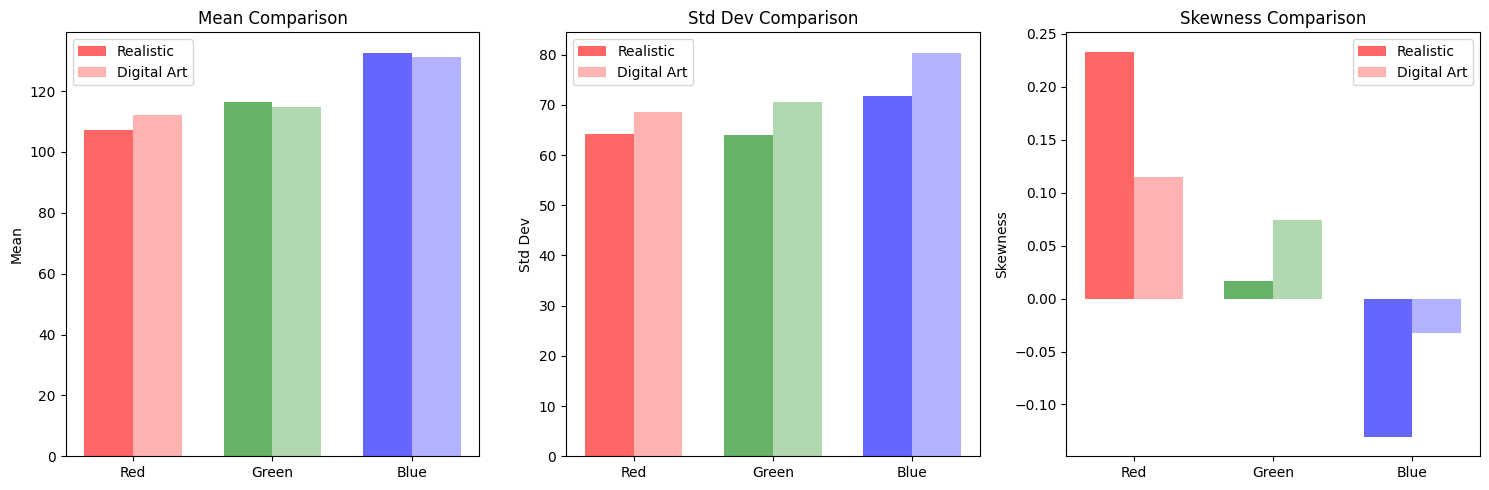

In [28]:
def extract_color_moments(image):
    """Extracts color moments: Mean, Standard Deviation, and Skewness for each RGB channel."""
    features = []
    for i in range(3):  # Iterate through R, G, B channels
        channel = image[:, :, i].flatten()
        features.extend([np.mean(channel), np.std(channel), skew(channel)])
    return np.array(features)

# Extract color moments for both datasets
realistic_moments = np.array([extract_color_moments(img) for img in realistic_images])
digital_moments = np.array([extract_color_moments(img) for img in digital_art_images])

# Compute the average color moments across all images in each dataset
mean_realistic_moments = np.mean(realistic_moments, axis=0)
mean_digital_moments = np.mean(digital_moments, axis=0)

# Labels for the features
color_labels = ['Red', 'Green', 'Blue']
moment_labels = ['Mean', 'Std Dev', 'Skewness']

# Plotting side-by-side bar charts for each moment (Mean, Std Dev, Skewness)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, moment in enumerate(moment_labels):
    bar_width = 0.35  # Bar width for side-by-side comparison
    x = np.arange(3)  # R, G, B positions

    axes[i].bar(x - bar_width / 2, mean_realistic_moments[i::3], bar_width, color=['r', 'g', 'b'], alpha=0.6, label="Realistic")
    axes[i].bar(x + bar_width / 2, mean_digital_moments[i::3], bar_width, color=['r', 'g', 'b'], alpha=0.3, label="Digital Art")

    axes[i].set_xticks(x)
    axes[i].set_xticklabels(color_labels)
    axes[i].set_title(f"{moment} Comparison")
    axes[i].set_ylabel(moment)
    axes[i].legend()

plt.tight_layout()
plt.show()


# 3 - Texture Descriptors Analysis

# 3.1 - GLCM (Gray-Level Co-occurrence Matrix) Analysis

GLCM Texture Properties:

    Contrast 🔳
        Measures the difference between neighboring pixel intensities.
        Higher contrast → More variations (e.g., rough textures).
        Lower contrast → Smoother regions.

    Homogeneity 📏
        Measures the closeness of pixel intensity distributions.
        Higher homogeneity → More uniform textures.
        Lower homogeneity → High-intensity variations.

    Energy ⚡
        Represents texture uniformity and repetition.
        Higher energy → More structured, repetitive patterns.
        Lower energy → More randomness in textures.

    Correlation 🔗
        Measures how correlated pixel intensities are across distances.
        Higher correlation → Strong spatial relationships in textures.
        Lower correlation → More randomness in pixel arrangements.

These features help in classifying textures, distinguishing between smooth, rough, structured, or random surfaces.

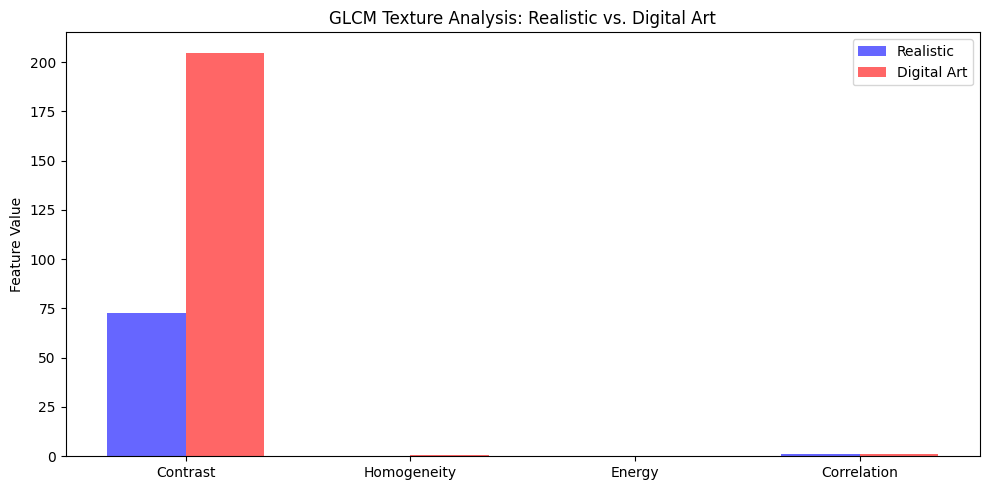

In [29]:
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray

def extract_glcm_features(image):
    """Extracts GLCM texture features: Contrast, Homogeneity, Energy, and Correlation."""
    gray = rgb2gray(image)  # Convert to grayscale
    glcm = graycomatrix((gray * 255).astype(np.uint8), distances=[1], angles=[0], levels=256)

    # Extract texture properties
    features = [
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0]
    ]
    return np.array(features)

# Extract GLCM features for both datasets
realistic_glcm = np.array([extract_glcm_features(img) for img in realistic_images])
digital_glcm = np.array([extract_glcm_features(img) for img in digital_art_images])

# Compute the average GLCM features across all images in each dataset
mean_realistic_glcm = np.mean(realistic_glcm, axis=0)
mean_digital_glcm = np.mean(digital_glcm, axis=0)

# GLCM feature labels
glcm_labels = ['Contrast', 'Homogeneity', 'Energy', 'Correlation']

# Plot side-by-side bar charts for GLCM features
fig, ax = plt.subplots(figsize=(10, 5))

bar_width = 0.35  # Bar width for side-by-side comparison
x = np.arange(len(glcm_labels))  # Positions for each feature

ax.bar(x - bar_width / 2, mean_realistic_glcm, bar_width, color='b', alpha=0.6, label="Realistic")
ax.bar(x + bar_width / 2, mean_digital_glcm, bar_width, color='r', alpha=0.6, label="Digital Art")

ax.set_xticks(x)
ax.set_xticklabels(glcm_labels)
ax.set_title("GLCM Texture Analysis: Realistic vs. Digital Art")
ax.set_ylabel("Feature Value")
ax.legend()

plt.tight_layout()
plt.show()


## 3.2 - Assessing the blur level and sharpness
**WIP**

# 4 - Frequency Analysis
# 4.1 - Fourier Transform

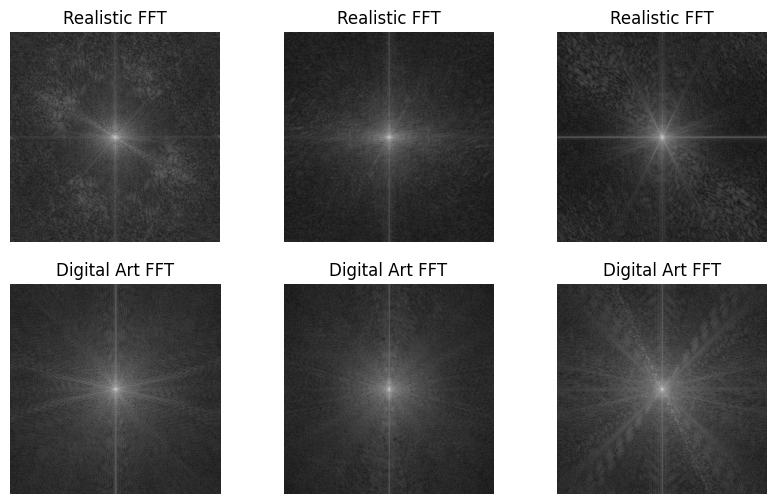

In [32]:
def fourier_spectrum(image):
    gray = rgb2gray(image)
    f_transform = fftshift(fft2(gray))
    magnitude_spectrum = np.log(np.abs(f_transform) + 1)
    return magnitude_spectrum

realistic_fft = [fourier_spectrum(img) for img in realistic_images]
digital_fft = [fourier_spectrum(img) for img in digital_art_images]

# Display Fourier Transform
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i in range(3):
    axes[0, i].imshow(realistic_fft[i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Realistic FFT")

    axes[1, i].imshow(digital_fft[i], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Digital Art FFT")
plt.show()

## 4.1 - Spectral Comparison
**WIP**

- Image Compression: Comparing the frequency components of a compressed image with the original image to assess quality and loss.
- Noise Removal: In signal processing, you might compare the spectral content of a signal before and after noise filtering to see how much noise has been removed.
- Pattern Recognition: Comparing the frequency spectra of signals to identify repeating patterns or anomalies.

# 5 - Facial Landmarks

## 5.1 - Facial Landmarks

In [34]:
!wget https://github.com/italojs/facial-landmarks-recognition/raw/refs/heads/master/shape_predictor_68_face_landmarks.dat

--2025-01-30 16:40:29--  https://github.com/italojs/facial-landmarks-recognition/raw/refs/heads/master/shape_predictor_68_face_landmarks.dat
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/refs/heads/master/shape_predictor_68_face_landmarks.dat [following]
--2025-01-30 16:40:29--  https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/refs/heads/master/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat’

shape_predicto

In [38]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
STANDARD_EYE_POSITIONS = np.float32([(40, 50), (80, 50)])

def extract_facial_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        return None
    landmarks = predictor(gray, faces[0])
    return face_utils.shape_to_np(landmarks)

realistic_landmarks = [extract_facial_landmarks(img) for img in realistic_images]
digital_landmarks = [extract_facial_landmarks(img) for img in digital_art_images]

In [40]:
print(f'realistic faces shape: {realistic_landmarks[0].shape}')
print(f'digital faces shape: {digital_landmarks[0].shape}')

realistic faces shape: (68, 2)
digital faces shape: (68, 2)


# 5.2 - Compute and Display Average Face

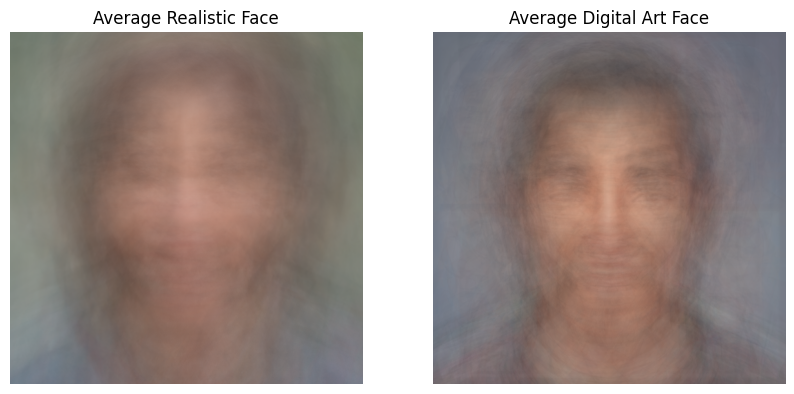

In [42]:
# 5.2 - Compute and Display Average Face
def compute_average_face(images):
    images = [img for img in images if img is not None]
    avg_face = np.mean(images, axis=0)
    return np.clip(avg_face, 0, 255).astype(np.uint8)

avg_realistic = compute_average_face(realistic_images)
avg_digital = compute_average_face(digital_art_images)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cv2.cvtColor(avg_realistic, cv2.COLOR_BGR2RGB))
axes[0].axis('off')
axes[0].set_title("Average Realistic Face")
axes[1].imshow(cv2.cvtColor(avg_digital, cv2.COLOR_BGR2RGB))
axes[1].axis('off')
axes[1].set_title("Average Digital Art Face")
plt.show()

# 5.3 - Align Faces and Generate Average Face

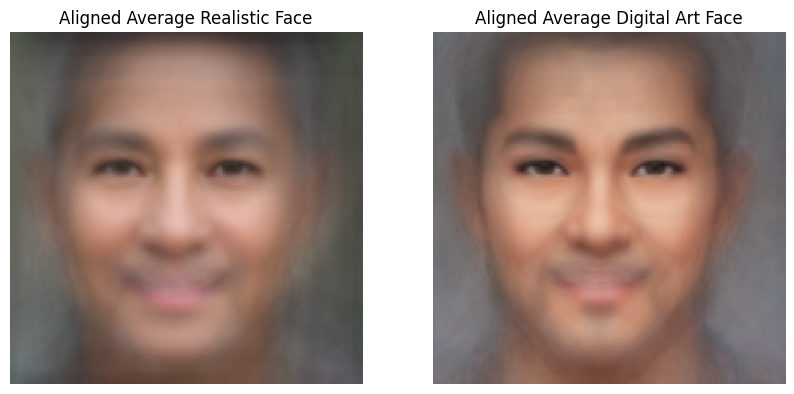

In [50]:
import numpy as np
import cv2
from imutils import face_utils

def align_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        return None
    landmarks = predictor(gray, faces[0])
    landmarks = face_utils.shape_to_np(landmarks)

    # Calculate the center of the eyes
    left_eye = np.mean(landmarks[36:42], axis=0)
    right_eye = np.mean(landmarks[42:48], axis=0)

    # Define standard eye positions (fixed standard)
    STANDARD_EYE_POSITIONS = np.float32([(40, 50), (80, 50)])

    # Calculate the distance between the eyes in the input image
    eye_dist = np.linalg.norm(right_eye - left_eye)

    # Calculate the distance between the eyes in the standard positions
    standard_eye_dist = np.linalg.norm(STANDARD_EYE_POSITIONS[1] - STANDARD_EYE_POSITIONS[0])

    # Compute scale factor (to maintain proportions)
    scale = standard_eye_dist / eye_dist

    # Calculate center of eyes in the input image
    eyes_center = (left_eye + right_eye) / 2

    # Compute translation: move eyes to the center of the standard positions
    translation = STANDARD_EYE_POSITIONS.mean(axis=0) - eyes_center

    # Compute the scaling matrix and apply the transformation
    transformation_matrix = cv2.getRotationMatrix2D(tuple(eyes_center), 0, scale)
    transformation_matrix[:, 2] += translation  # Apply translation

    # Apply affine transformation
    aligned_face = cv2.warpAffine(image, transformation_matrix, (128, 128))

    return aligned_face

# Test the alignment on realistic and digital images
realistic_aligned = [align_face(img) for img in realistic_images]
digital_aligned = [align_face(img) for img in digital_art_images]

# Assuming compute_average_face is already defined
avg_realistic_aligned = compute_average_face(realistic_aligned)
avg_digital_aligned = compute_average_face(digital_aligned)

# Display the average aligned faces
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cv2.cvtColor(avg_realistic_aligned, cv2.COLOR_BGR2RGB))
axes[0].axis('off')
axes[0].set_title("Aligned Average Realistic Face")
axes[1].imshow(cv2.cvtColor(avg_digital_aligned, cv2.COLOR_BGR2RGB))
axes[1].axis('off')
axes[1].set_title("Aligned Average Digital Art Face")
plt.show()

